In [2]:
# https://www.kaggle.com/c/m5-forecasting-accuracy/data
# !kaggle competitions download -c m5-forecasting-accuracy

 98%|█████████████████████████████████████▎| 45.0M/45.8M [00:04<00:00, 11.5MB/s]
100%|██████████████████████████████████████| 45.8M/45.8M [00:04<00:00, 10.3MB/s]


In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import statsmodels.api as sm

MAX_ROWS = 12195 # enought to get every CA instance
make_path = lambda file: os.path.join('data', file)

## We want to predict item sales at stores 

- calendar.csv - Contains information about the dates on which the products are sold.

- sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]

- sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.

- sell_prices.csv - Contains information about the price of the products sold per store and date.

- sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

calendar.csv

I believe the date - as a number, does not truly influence buying habits. However, birthdays, events and commemorative dates sure influence buying habits: we need a way to code this into the model. 

- wday
- season (by date)
- event_name_1
- event_type_1

sales

- id is not important as it's one for each row
- item_id will give us the price of each product: does the price influences buying habits? Because we want to know sales **for each** item, knowing it's dept_id or category won't give us more information - however, for viz it might be interesting to plot by dept, for example.
- store_id will be important as we want to predict sales per store

We have 1947 - (10 - 4)  = 1941 days of data and want to predict 2 * 28 = 56 days ~ 1941/56 = 34.66

sell_prices

- prices vary by date, thus we need to link those things

## Data Importing 

In [2]:
os.listdir('data')

['sales_train_evaluation.csv',
 'calendar.csv',
 'sell_prices.csv',
 'sales_train_validation.csv',
 'sample_submission.csv']

In [3]:
gb_key = 'store_id'

In [4]:
df_calendar = pd.read_csv(
    make_path('calendar.csv'), 
)
df_sales = pd.read_csv(
    make_path('sales_train_evaluation.csv'), 
    nrows = MAX_ROWS
).drop(columns = ['id'])
print(f'Imported {df_sales.shape}')
assert df_sales.state_id.nunique() == 1, df_sales.state_id.unique()

Imported (12195, 1946)


In [5]:
days = df_sales.columns[df_sales.columns.str.startswith('d_')]

## Data Viz

### Let's understand how the prices are distributed

In [6]:
d_prices = pd.read_csv(
    make_path('sell_prices.csv')
)

In [7]:
gb_prices = d_prices\
    .groupby('item_id')\
    .agg({'sell_price': [np.mean, np.std]})

In [8]:
gb_prices.sort_values(
    by = ('sell_price', 'std'), 
    ascending = False
).head(3)

sell_price          
                      mean       std
item_id                             
HOUSEHOLD_2_406  12.846283  4.784952
HOUSEHOLD_2_466   7.533100  4.421793
HOUSEHOLD_2_292  12.565442  2.523309

In [9]:
gb_prices[('sell_price', 'std')].std()

0.23225396427264186

Because it's standard deviation is low, I will use the price mean over time to use as a variable for the model - otherwise, we could create a dict indexed by it's (store_id, item_id, wm_yr_wk), like:

In [10]:
if False:    
    d_prices = pd.read_csv(
        make_path('sell_prices.csv')
    ).set_index(
        [gb_key, 'item_id', 'wm_yr_wk']
    ).sell_price.to_dict()

However, we can see that one of the items has a std that is considerable (~1/3 of it's mean), let's see it historical price

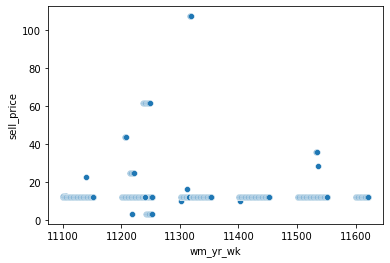

In [11]:
sns.scatterplot(
    data = d_prices[d_prices.item_id == 'HOUSEHOLD_2_406'],
    x = 'wm_yr_wk',
    y = 'sell_price'
);

What happened to have such a spike in price?

In [12]:
idxmax = d_prices[d_prices.item_id == 'HOUSEHOLD_2_406']\
    .sell_price\
    .idxmax()
day = d_prices.loc[idxmax, 'wm_yr_wk']
df_calendar[df_calendar.wm_yr_wk == day]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
840,2013-05-18,11317,Saturday,1,5,2013,d_841,NaN,NaN,NaN,NaN,0,0,0
841,2013-05-19,11317,Sunday,2,5,2013,d_842,NaN,NaN,NaN,NaN,0,0,0
842,2013-05-20,11317,Monday,3,5,2013,d_843,NaN,NaN,NaN,NaN,0,0,0
843,2013-05-21,11317,Tuesday,4,5,2013,d_844,NaN,NaN,NaN,NaN,0,0,0
844,2013-05-22,11317,Wednesday,5,5,2013,d_845,NaN,NaN,NaN,NaN,0,0,0
845,2013-05-23,11317,Thursday,6,5,2013,d_846,NaN,NaN,NaN,NaN,0,0,0
846,2013-05-24,11317,Friday,7,5,2013,d_847,NaN,NaN,NaN,NaN,0,0,0


There isn't any event to explain the price, so we are in the dark here

In [13]:
del d_prices

### Let's understand our Sales by Store data

#### Let's look at CAT_ID

In [15]:
def count_sold(x): 
    return np.sum(x > 1)

agg_cat = df_sales\
    .groupby(by = 'cat_id')\
    .agg({d: [np.sum, count_sold] for d in days})

In [16]:
agg_cat.head()

d_1              d_2              d_3              d_4  \
             sum count_sold   sum count_sold   sum count_sold   sum   
cat_id                                                                
FOODS      10101       1320  9862       1276  6944       1063  7864   
HOBBIES     1802        251  1561        228  1472        187  1405   
HOUSEHOLD   2292        481  2382        504  1692        373  1778   

                       d_5             ... d_1937            d_1938  \
          count_sold   sum count_sold  ...    sum count_sold    sum   
cat_id                                 ...                            
FOODS           1085  7178       1078  ...  10462       1891  10646   
HOBBIES          212  1181        201  ...   1606        308   1735   
HOUSEHOLD        374  1566        324  ...   3607        764   3912   

                     d_1939            d_1940            d_1941             
          count_sold    sum count_sold    sum count_sold    sum count_sold  
cat_id                                                                      
FOODS           1904  11349       2017  14485       2451  15970       2599  
HOBBIES          323   1975        392   2701        433   2514        455  
HOUSEHOLD        826   4101        867   5913       1220   6160       1278  

[3 rows x 3882 columns]

In [20]:
agg_cat_melted = pd.melt(
    agg_cat,  
    ignore_index = False,
).rename(
    columns = {'variable_0': 'day', 'variable_1': 'func'}
)
agg_cat_melted.head()

,day,func,value
cat_id,,,
FOODS,d_1,sum,10101
HOBBIES,d_1,sum,1802
HOUSEHOLD,d_1,sum,2292
FOODS,d_1,count_sold,1320
HOBBIES,d_1,count_sold,251


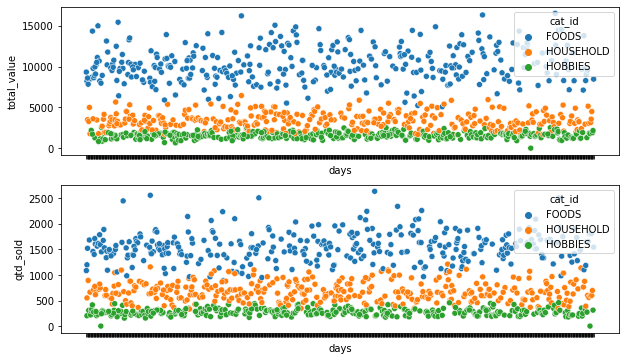

In [58]:
fig, (ax_0, ax_1) = plt.subplots(2, 1, figsize = (10, 6))

selected_agg_cat_melted = agg_cat_melted.sample(2_000)
hue_order = selected_agg_cat_melted.index.unique()

sum_data = selected_agg_cat_melted[
        selected_agg_cat_melted.func == 'sum'
]

count_data = selected_agg_cat_melted[
        selected_agg_cat_melted.func == 'count_sold'
]

sns_plot = sns.scatterplot(
    data = sum_data,
    x = 'day',
    y = 'value',
    hue = 'cat_id',
    hue_order = hue_order,
    ax = ax_0
);

sns_plot.set(xlabel = 'days', ylabel = 'total_value', xticklabels=[])

sns_plot = sns.scatterplot(
    data = count_data,
    x = 'day',
    y = 'value',
    hue = 'cat_id',
    hue_order = hue_order,
    ax = ax_1
);

sns_plot.set(xlabel = 'days', ylabel = 'qtd_sold', xticklabels=[])

plt.show()

It looks like there is no real pattern behind neither the amount of items sold or how much was collected. 

However we can confirm that the item that is most selled and which corresponds to most of the money is part of the FOODS department - thus, we will divide our analysis for each of the departments

In [59]:
df_sales.head()

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [64]:
df_sales.dept_id.unique()

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

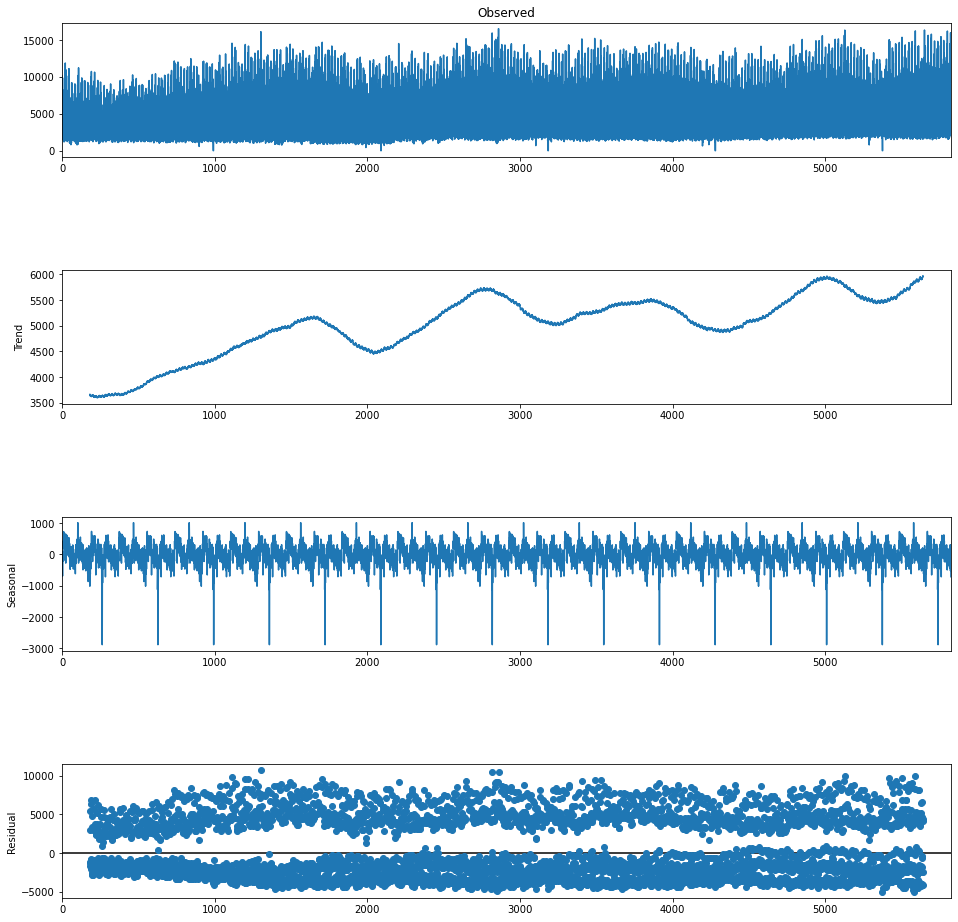

In [130]:
x = agg_cat_melted[agg_cat_melted.func == 'sum'].value.values

res = sm.tsa.seasonal_decompose(x, period = 365)
fig = res.plot()
fig.set_figheight(15)
fig.set_figwidth(15)
plt.show()

The money spent on walmart has grown over time, an it also has a sazonality, as you can observe above

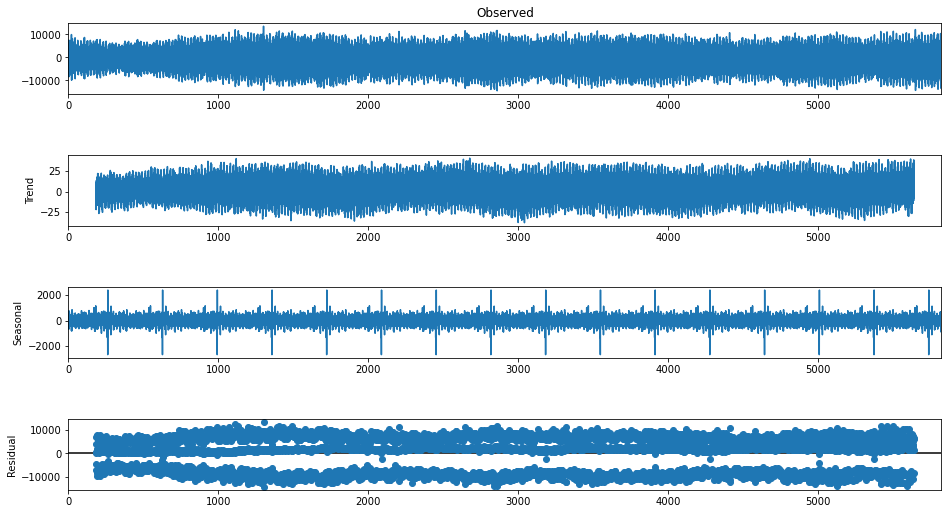

In [155]:
res = sm.tsa.seasonal_decompose(np.diff(x), period = 365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

Now you can observe that the first different took the growth out

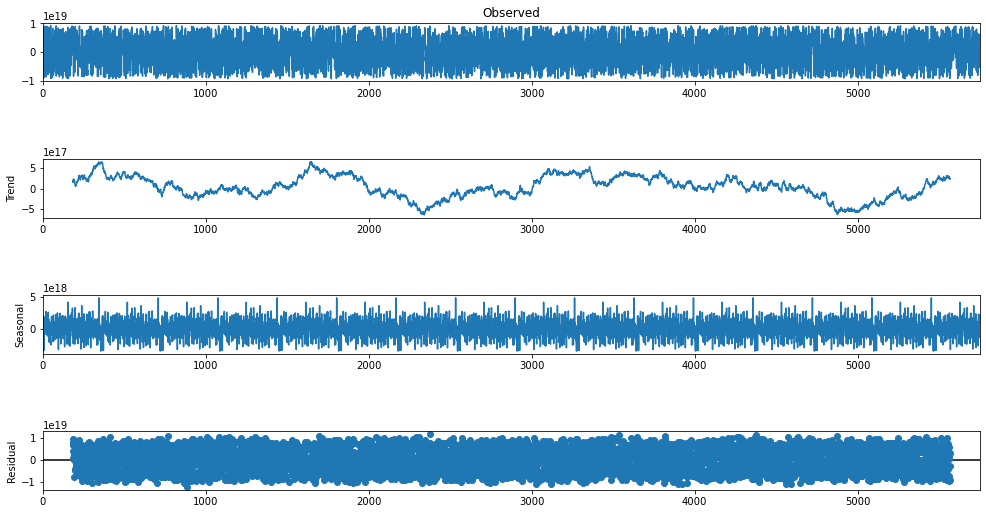

In [154]:
res = sm.tsa.seasonal_decompose(np.diff(x, n = 365//5), period = 365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

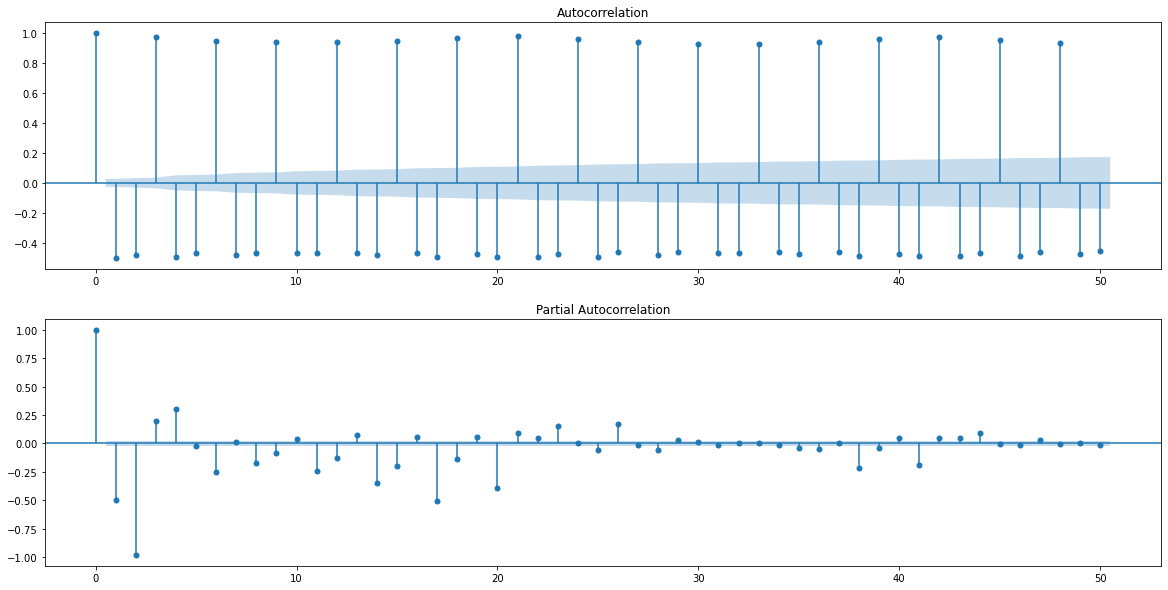

In [146]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(np.diff(x), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(np.diff(x), lags=50, ax=ax[1])
plt.show()

## Merging Data to build a model

We will need to transform Sales DataFrame into a feature matrix that let's us isolate the logic STATE_ID > STORE_ID > DEPT_ID > ITEM_ID . However, by now, we will just predict *how much a store sold, by dept*

In [92]:
df_feature = df_sales.copy()

Because we understood that the prices don't vary too much, we will use it's mean

In [97]:
df_feature = df_feature.merge(
    pd.melt(
        gb_prices[('sell_price', 'mean')].to_frame(),
        var_name = [],
        ignore_index = False
    ), 
    left_on = 'item_id', 
    right_index = True
).reset_index(drop = True)

Now we create a dummie for every categorical feature 

In [99]:
categorical = [
    'state_id', 'store_id', 'cat_id', 'dept_id', 'item_id'
]

df_feature = pd.concat(
    [
        pd.get_dummies(
            df_feature[categorical],
            drop_first = True
        ),
        df_feature[days]
    ],
    axis = 1
)

## Feature Engineering 

We need to join the events information, seasons and weekends markers to our data - then we will train a SARIMAX model to have an idea of what is important. 

In [148]:
# season, weekend and events dummies

## Model Training and Evaluation

## Results